In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow info logs

from models import *

2024-12-02 14:18:39.553176: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733170719.562855   95435 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733170719.565729   95435 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
s = segmentation_model()

I0000 00:00:1733170720.936308   95435 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9897 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


In [3]:
import tensorflow as tf
nan_value = tf.constant(float('nan'), dtype=tf.float32)
input0 = tf.Variable(tf.zeros([1, *NEW_INPUT_SHAPE], dtype=tf.float32))  # Example tensor

indices = [[0, 0, 0, 0]]
updates = [nan_value]
input0 = tf.tensor_scatter_nd_update(input0, indices, updates)

In [4]:
print(nan_value)

tf.Tensor(nan, shape=(), dtype=float32)


In [5]:
output0 = s(input0)

I0000 00:00:1733170721.454950   95435 cuda_dnn.cc:529] Loaded cuDNN version 90300


In [6]:
num_nans_inputs = tf.reduce_sum(tf.cast(tf.math.is_nan(input0), tf.int32)).numpy()
num_nans = tf.reduce_sum(tf.cast(tf.math.is_nan(output0), tf.int32)).numpy()
print(f"Number of NaNs in input0: {num_nans_inputs} (shape: {input0.shape})")
print(f"Number of NaNs in output0: {num_nans} (shape: {output0.shape})")

Number of NaNs in input0: 1 (shape: (1, 15360, 256, 3))
Number of NaNs in output0: 2048 (shape: (1, 3840, 64, 32))


In [7]:
import keras
from keras.models import Model
from keras.layers import Dense, Input, Concatenate
from keras.optimizers import Adam
import tensorflow as tf

class MINE(Model):
    def __init__(self, input_dim, hidden_dim):
        super(MINE, self).__init__()
        # Define the network for MI estimation
        self.dense1 = Dense(hidden_dim, activation='relu')
        self.dense2 = Dense(hidden_dim, activation='relu')
        self.output_layer = Dense(1)
    
    def call(self, x, y):
        # Joint distribution input
        joint_input = Concatenate(axis=1)([x, y])
        joint_score = self.output_layer(self.dense2(self.dense1(joint_input)))
        
        # Marginal distribution input (shuffled y)
        shuffled_y = tf.random.shuffle(y)
        marginal_input = Concatenate(axis=1)([x, shuffled_y])
        marginal_score = self.output_layer(self.dense2(self.dense1(marginal_input)))
        
        return joint_score, marginal_score


In [8]:
def train_mine(mine_model, x, y, epochs=1000, lr=1e-3, batch_size=128):
    optimizer = Adam(learning_rate=lr)

    # Custom training step
    @tf.function
    def train_step(x_batch, y_batch):
        with tf.GradientTape() as tape:
            # Forward pass
            joint_score, marginal_score = mine_model(x_batch, y_batch)
            
            # MI estimation
            mi_estimation = tf.reduce_mean(joint_score) - tf.math.log(tf.reduce_mean(tf.exp(marginal_score)))
            
            # Loss for optimization (negative MI)
            loss = -mi_estimation
        
        # Backpropagation
        gradients = tape.gradient(loss, mine_model.trainable_variables)
        clipped_gradients = [tf.clip_by_value(g, -5.0, 5.0) for g in gradients]
        optimizer.apply_gradients(zip(clipped_gradients, mine_model.trainable_variables))
        
        return mi_estimation

    # Prepare dataset
    dataset = tf.data.Dataset.from_tensor_slices((x, y)).shuffle(buffer_size=1024).batch(batch_size)
    
    for epoch in range(epochs):
        for x_batch, y_batch in dataset:
            mi_estimation = train_step(x_batch, y_batch)
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, MI Estimation: {mi_estimation.numpy()}")
    
    return mi_estimation.numpy()


def train_mine_with_logging(mine_model, x, y, epochs=1000, lr=1e-3, batch_size=128):
    optimizer = Adam(learning_rate=lr)
    mi_history = []

    @tf.function
    def train_step(x_batch, y_batch):
        with tf.GradientTape() as tape:
            joint_score, marginal_score = mine_model(x_batch, y_batch)
            mi_estimation = tf.reduce_mean(joint_score) - tf.math.log(tf.reduce_mean(tf.exp(marginal_score)))
            loss = -mi_estimation
        gradients = tape.gradient(loss, mine_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, mine_model.trainable_variables))
        return mi_estimation

    dataset = tf.data.Dataset.from_tensor_slices((x, y)).shuffle(buffer_size=1024).batch(batch_size)

    for epoch in range(epochs):
        for x_batch, y_batch in dataset:
            mi_estimation = train_step(x_batch, y_batch)
        mi_history.append(mi_estimation.numpy())
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, MI Estimation: {mi_estimation.numpy()}")

    return mi_history



Epoch 0, MI Estimation: 0.021013855934143066
Epoch 100, MI Estimation: 1.0271501541137695
Epoch 200, MI Estimation: 0.9819941520690918
Epoch 300, MI Estimation: 1.1391417980194092
Epoch 400, MI Estimation: 1.1324529647827148
Epoch 500, MI Estimation: 1.0229671001434326
Epoch 600, MI Estimation: 1.096998929977417
Epoch 700, MI Estimation: 1.1062214374542236
Epoch 800, MI Estimation: 1.2766132354736328
Epoch 900, MI Estimation: 0.9776821136474609


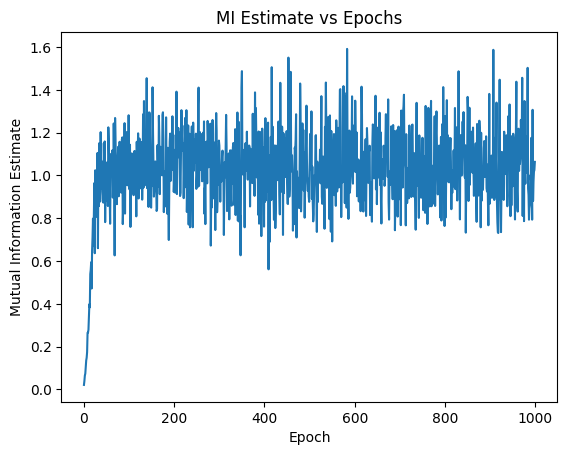

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Example: Generate random data
num_samples = 1000
x = np.random.rand(num_samples, 1).astype(np.float32)  # Input features
y = (x + np.random.normal(0, 0.1, size=(num_samples, 1))).astype(np.float32)  # Labels with noise

# Instantiate and train MINE
mine_model = MINE(input_dim=2, hidden_dim=32)
# Training and logging
mi_history = train_mine_with_logging(mine_model, x, y, epochs=1000, lr=1e-3, batch_size=128)

# Plot MI estimate
plt.plot(range(len(mi_history)), mi_history)
plt.xlabel('Epoch')
plt.ylabel('Mutual Information Estimate')
plt.title('MI Estimate vs Epochs')
plt.show()
